# Course Project: Image Analysis for cancer risk assessment (8QA01)


Welcome to the project of 8QA01! This notebook contains the steps to go through the images, measure features and display measurements, using functions in the utilities_8qa01.py module. You can add extend this by adding more functions in the module, and calling them from this notebook.


Before you start, don't forget to:

- Read the README.md file in this repository
- Do the "Getting started" [essential skills](https://github.com/tueimage/essential-skills) tutorial on Python



# Step-by-step project walkthrough

## 0. Import required python packages

These packages contain different functionality, for example matplotlib.pyplot is useful for various visualisation techniques. You can import more packages than these, as long as they are common Python packages, or you include them with your code. 


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Groep_05_functions as util
from skimage import morphology
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

## 1. Specify data locations

Change the dataFile variable according to the image set you are using 

In [2]:
dataFile = 'class2020_group05_labels.xlsx'
imagePath = 'C:\\Users\Administrator\Documents\OGO beeldanalyse\Onze data'
maskPath = 'C:\\Users\Administrator\Documents\OGO beeldanalyse\Onze data maskers'

## 2. Load data

In [3]:
dframe = pd.read_excel(dataFile)

#print(dframe)

## 3. Initialise variables

In [4]:
ID = list(dframe['id'])
Melanoma = np.array(dframe['melanoma'])
numImages = len(ID)
featuresBorder = np.empty([numImages,1])
featuresBorder[:] = np.nan
featuresColor = np.empty([numImages,1])
featuresColor[:] = np.nan
featuresAsymmetry = np.empty([numImages,1])
featuresAsymmetry[:] = np.nan
featuresColor2 = np.empty([numImages,1])
featuresColor2[:] = np.nan



## 4. Measure features for all images

In [5]:
for i in np.arange(numImages):
    
    # Define filenames related to this image
    imFile = imagePath + os.sep + ID[i] + '.jpg'
    maskFile = maskPath + os.sep + ID[i] + '_segmentation.png'
    
    # Read the images with these filenames
    im = plt.imread(imFile)
    mask = plt.imread(maskFile)
    
    #Draai de foto
    #mask, im = util.image_rotation(im, mask) Doet het niet
    
    # Measure features
    border_score, border = util.border_evaluation(mask)
    color_score = util.color_cluster_evaluation(im, mask)
    color_score_2 = util.colour_evaluation(im, mask)
    #asymmetry_score = util.symmetry_evaluation(im, mask) Werkt niet zolang draaien niet werkt
    # xx, yy, zz = util.measureYourOwnFeatures(mask)
    
    # Store in the variables we created before
    featuresBorder[i,0] = border_score
    featuresColor[i,0] = color_score
    featuresColor2[i,0] = color_score_2
    #featuresAsymmetry[i,0] = asymmetry_score
    # featuresOther[i,0] = xx

## 5. Save measured data

In [6]:
outfile = 'group2020_05_automatic.csv'
outdata = {"id": ID, 
           "border": featuresBorder.flatten(),
           "color": featuresColor.flatten(),
           "color2": featuresColor2.flatten()}

dframe_out = pd.DataFrame(outdata)
dframe_out.to_csv(outfile, index=False)

## 6. Display measured data

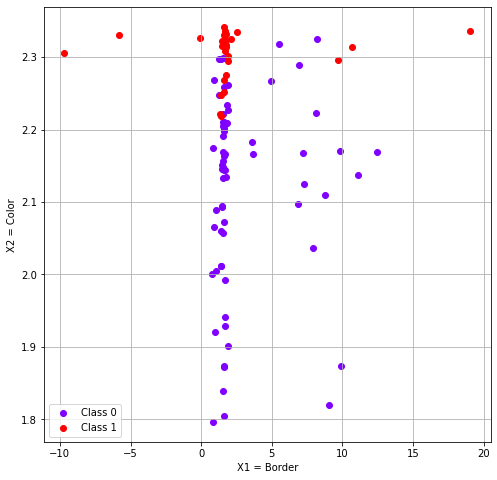

In [7]:
# Load the data you saved, then do some analysis
outfile = 'group2020_05_automatic.csv'
dframe = pd.read_csv(outfile)
ID = list(dframe['id'])
featuresBorder = np.array(dframe['border'])
featuresColor = np.array(dframe['color'])
featuresColor2 = np.array(dframe['color2'])

# Display 2 features measured in a scatterplot, 
axs = util.scatter_data(featuresBorder, featuresColor, Melanoma)
axs.set_xlabel('X1 = Border')
axs.set_ylabel('X2 = Color')
axs.legend()

## 7. Predict labels using measurements

Accuracy of predictions on test set of fold 1: 0.8
Accuracy of validation set was 0.9 with K: 1
Accuracy of predictions on test set of fold 2: 0.8
Accuracy of validation set was 0.85 with K: 1
Accuracy of predictions on test set of fold 3: 0.95
Accuracy of validation set was 0.85 with K: 1
Accuracy of predictions on test set of fold 4: 0.95
Accuracy of validation set was 0.9 with K: 7
Accuracy of predictions on test set of fold 5: 0.5
Accuracy of validation set was 1.0 with K: 2


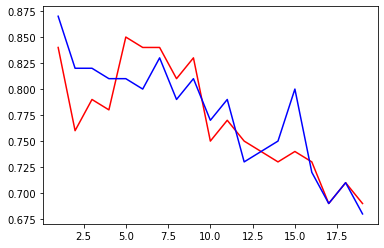

In [14]:
#Define K's that are tested on the validation set and the number of the current fold
Validation_K = range(1, 20)
curr_fold = 0
# Load features
X = dframe.iloc[:,1:].to_numpy()
# Load labels
y = Melanoma
all_acc_test= np.empty([5, 19])
all_acc_test[:] = np.nan
all_acc_val=np.empty([5, 19])
all_acc_val[:]=np.nan

# Split dataset into 5 different dataset folds for cross-validation
kf = StratifiedShuffleSplit(n_splits=5, test_size=0.4, random_state=1)
# Predict labels for each fold using the KNN algortihm
for train_index, test_val_index in kf.split(X, y):
    
    #For making a plot of test acc and val acc over multiple K
    #acc_test_list = [] Commented because average is plotted
    #acc_val_list = []
    
    best_K = 0
    # Define accuracy score and predictions for test set
    Acc_Score = 0
    y_pred_test = 0
    # split dataset into a train, validation and test dataset
    test_index , val_index = np.split(test_val_index, 2)
    X_train, X_val, X_test = X[train_index], X[val_index], X[test_index]
    y_train, y_val, y_test = y[train_index], y[val_index], y[test_index]
    # Generate predictions using knn_classifier for every K
    for K in Validation_K:        
        y_pred_val, y_pred_test_curr = util.knn_classifier(X_train, y_train, X_val, X_test, K)
        Curr_Acc = accuracy_score(y_val,y_pred_val)
        # If accuracy of the predictions on the validation set is larger than the current accuracy, save predictions
        # for test set
        
        #Measure test set and store these values
        test_acc_curr = accuracy_score(y_test,y_pred_test_curr)
        acc_test_list.append(test_acc_curr)
        acc_val_list.append(Curr_Acc)
        
        if Curr_Acc > Acc_Score:
            Acc_Score = Curr_Acc
            y_pred_test = y_pred_test_curr
            best_K = K
    # Add 1 to the number of the current fold and print the accuracy on the test set for the current fold
    #plt.plot(acc_test_list, 'r-') Plot accuracy for each fold
    #plt.plot(acc_val_list, 'b-') Commented because average is plotted
    all_acc_val[curr_fold, :] = acc_val_list
    all_acc_test[curr_fold, :] = acc_test_list
    curr_fold += 1
    plt.xlabel = "K"
    plt.ylabel = "Accuracy"
    test_acc = accuracy_score(y_test,y_pred_test)
    print('Accuracy of predictions on test set of fold '+ str(curr_fold)+ ': ' + str(test_acc))
    print('Accuracy of validation set was '+ str(Acc_Score) + ' with K: '+str(best_K))

#Plot average accuracies for all K's
gem_acc_test=[] # Initialise variables for storing average accuracies
gem_acc_val=[]
for i in range(19):
    acc_val = all_acc_val[:, i] # Take the accuracies of a certain K
    acc_test = all_acc_test[:, i]
    gem_acc_test.append(np.sum(acc_test)/len(acc_test)) # Calculate and store average accuracy
    gem_acc_val.append(np.sum(acc_val)/len(acc_val))
plt.plot(Validation_K, gem_acc_test,'r-') # Plot these average accuracies for each K
plt.plot(Validation_K, gem_acc_val, 'b-')